In [1]:
import shap
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, f1_score
from util.build_criterion import *
from util.data_loader import DataSetAD, DataSetADFew
from util.utils import aucPerformance, dataLoading
from TransformerForAdLiner import ADTransformer
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle
from TransformerForAdLinerNewNet import ADTransformer
import torch

In [3]:
dataset_information = [
                       ['bank-additional-full-deonehot', 'Bank', 41189, 20, 4, 0.3],
                       ['celeba_baldvsnonbald_normalised','CelebA',202600, 39, 3, 0.6],
                        ['census-income-full-mixed-binarized', 'Census', 299286, 100, 25, 0.14],
                       ['creditcardfraud_normalised', 'Fraud',284808, 29, 1, 0.5],
                       ['shuttle_normalization', 'Shuttle',49098, 9, 3, 0.6],
                        ['annthyroid_21feat_normalised', 'Thyroid', 7201, 21, 3, 0.5],
                       ['UNSW_NB15_traintest_backdoor-deonehot', 'Backdoor', 95330, 42, 6, 0.5],
                       ['mammography_normalization', 'Mammography', 11183, 6, 1, 0.4]
                        ] #no
# x = np.load('./FeatureData/'+dataset_information[6][0]+'_val.npy', allow_pickle=True)
# y = np.load('./FeatureData/'+dataset_information[6][0]+'_val_labels.npy', allow_pickle=True)
block_size = dataset_information[0][3]
sample_size = dataset_information[0][4]
dataset_select = dataset_information[0][0]
name = dataset_information[0][1]

## 获取数据集和边界值

In [4]:
score_data = pd.read_csv('./PreDataForModel/'+dataset_select+'_val_results.csv')
max_value = score_data['pre_val'].max()+0.0005
min_value = score_data['pre_val'].min()-0.0005
print(max_value,min_value)

0.46703298 0.003480453


In [5]:
all_data = pd.read_csv('./FeatureDataForModel/'+dataset_select+'_val.csv')
x_df = all_data.drop(['class'],axis=1)
y_df = all_data['class']

In [6]:
# 获取全为0和1的标签
x_ones = all_data[all_data['class']==1]
x_zeros = all_data[all_data['class']==0]

## 划分机器学习数据集

In [7]:

X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=42, shuffle=True )

In [8]:
np.where(y_test==1)

(array([   0,    1,    2,    4,    5,   10,   12,   15,   16,   18,   19,
          20,   24,   28,   30,   31,   34,   36,   40,   42,   43,   44,
          45,   46,   47,   48,   53,   54,   58,   59,   60,   61,   66,
          68,   70,   71,   72,   75,   77,   81,   83,   84,   88,   91,
          93,   96,   97,   99,  102,  104,  106,  108,  109,  112,  115,
         116,  117,  118,  120,  121,  122,  123,  124,  127,  128,  129,
         130,  133,  134,  136,  137,  139,  140,  141,  142,  148,  149,
         150,  151,  152,  155,  156,  166,  167,  168,  171,  172,  174,
         175,  176,  177,  178,  179,  181,  185,  186,  188,  189,  190,
         192,  193,  194,  196,  197,  199,  201,  203,  205,  211,  212,
         214,  215,  218,  221,  222,  225,  226,  227,  228,  231,  235,
         236,  237,  238,  240,  245,  248,  249,  250,  252,  253,  254,
         255,  257,  258,  260,  261,  264,  265,  266,  267,  270,  272,
         273,  274,  275,  278,  281, 

## 构造深度学习网络

In [9]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
MHCS_model = ADTransformer(block_size=block_size, num_layers=8, heads= sample_size , device=device).to(device)
MHCS_model.eval()

state_dict = torch.load('./Model_best/Transformer_Base_'+ dataset_select +'.pt', map_location=device)
MHCS_model.load_state_dict(state_dict)

<All keys matched successfully>

## 构造解释器

In [10]:
torch.tensor(X_test.iloc[1], dtype=torch.float32).view(1,-1).shape
# X_test.iloc[1].shape

torch.Size([1, 20])

In [30]:
def MHCS_PredictProba(X_test):
    # 单条数据预处理和转换
    input_data = torch.tensor(X_test, dtype=torch.float32)  # 假设数据维度为(10,)
    if input_data.ndim == 1:
        input_data = input_data.view(1,-1)
    input_data_copy = input_data
    if input_data.size(0) == 1:
        input_data_copy = torch.cat((input_data, input_data), dim=0)
    all_proba = []
    with torch.no_grad():
        output = MHCS_model(input_data_copy).cpu()
        if input_data.size(0) == 1:
            output = torch.mean(output).unsqueeze(0).unsqueeze(0)
        # print(output)
        for i in output.numpy():
            data = (i-min_value)/(max_value-min_value)
            all_proba.append(np.array([1-data, data]).reshape(1, 2).tolist())
        all_proba = np.concatenate(all_proba)
    return all_proba[:, 1]

In [31]:
explainer = shap.Explainer(MHCS_PredictProba, X_train.median().values.reshape((1, X_train.shape[1])))

In [27]:
shap_values = explainer(X_train.iloc[0:1000, :])

PermutationExplainer explainer: 1001it [10:37,  1.55it/s]                                                              


In [28]:
# 获取0值shap
shap_ones = explainer(X_train.iloc[np.where(y_train.values==1)])

PermutationExplainer explainer: 2939it [30:11,  1.61it/s]                                                              


In [33]:
# 获取0值shap
shap_zeros = explainer(X_train.iloc[np.where(y_train.values==0)])

PermutationExplainer explainer: 3309it [36:30,  1.50it/s]                                                              


In [21]:
np.where(y_train.values==1)

(array([   1,    3,    5, ..., 6242, 6243, 6245], dtype=int64),)

## 绘图

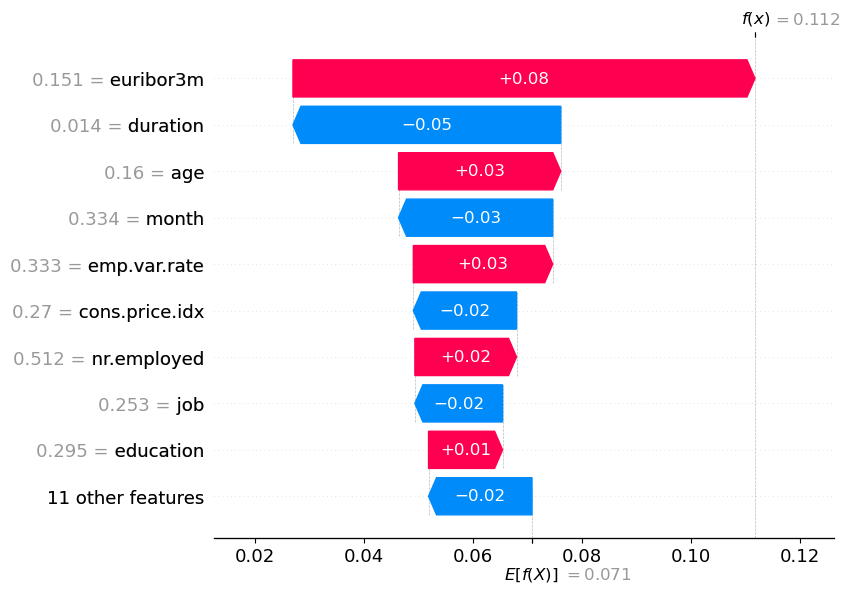

In [30]:
shap.plots.waterfall(shap_values[14])

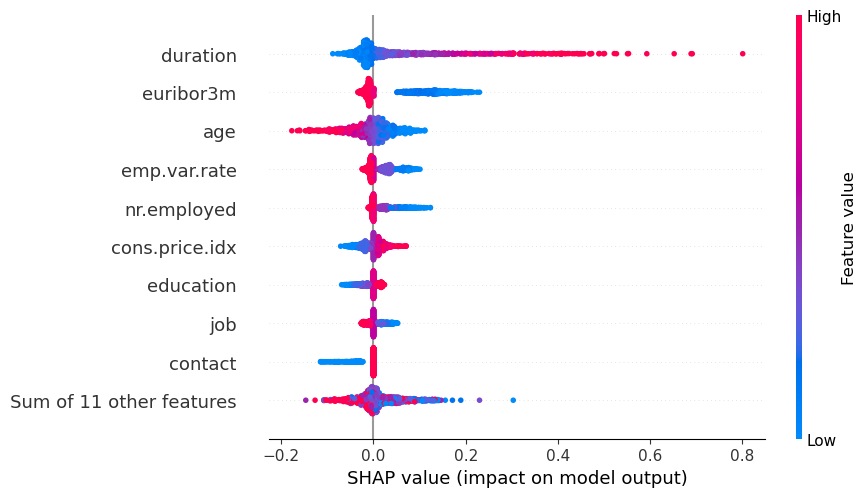

In [31]:
shap.plots.beeswarm(shap_values,show=False)
plt.savefig('./ShapPic/'+'{}'.format(dataset_select)+'shap分析.png') # 保存图像

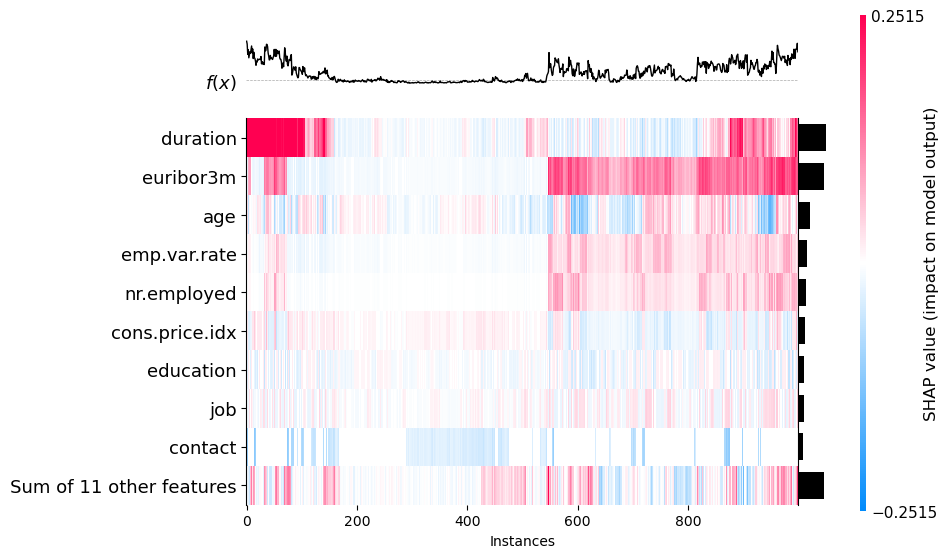

In [32]:
plt.figure(figsize=(8, 8))
shap.plots.heatmap(shap_values,show=False)
plt.savefig('./ShapPic/'+'{}'.format(dataset_select)+'shap分析.png', dpi=300,  bbox_inches='tight') # 保存图像

## 保存shap_value值

In [10]:
import pickle

In [48]:
type(shap_values)

shap._explanation.Explanation

In [52]:
with open('./ShapExplanationData/'+"{}_explanation.pkl".format(name), 'wb') as f:
    pickle.dump(shap_values, f)

In [53]:
# 加载保存的 Explanation 对象
with open('./ShapExplanationData/'+"{}_explanation.pkl".format(name), 'rb') as f:
    loaded_explanation = pickle.load(f)

## KernelExplainer
KernelExplainer是SHAP库中的一种基于核函数的解释器。它通过对模型进行近似拟合，从而计算每个特征对预测结果的SHAP值。KernelExplainer适用于任何类型的模型，包括黑盒模型，在训练数据集较小的情况下也可以获得较好的近似效果。

In [33]:
explainer_Kernel = shap.KernelExplainer(MHCS_PredictProba, X_train.iloc[0:100, :].values, link='logit')

In [35]:
shap_values_Kernel = explainer_Kernel(X_train.iloc[0:10, :].values)

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

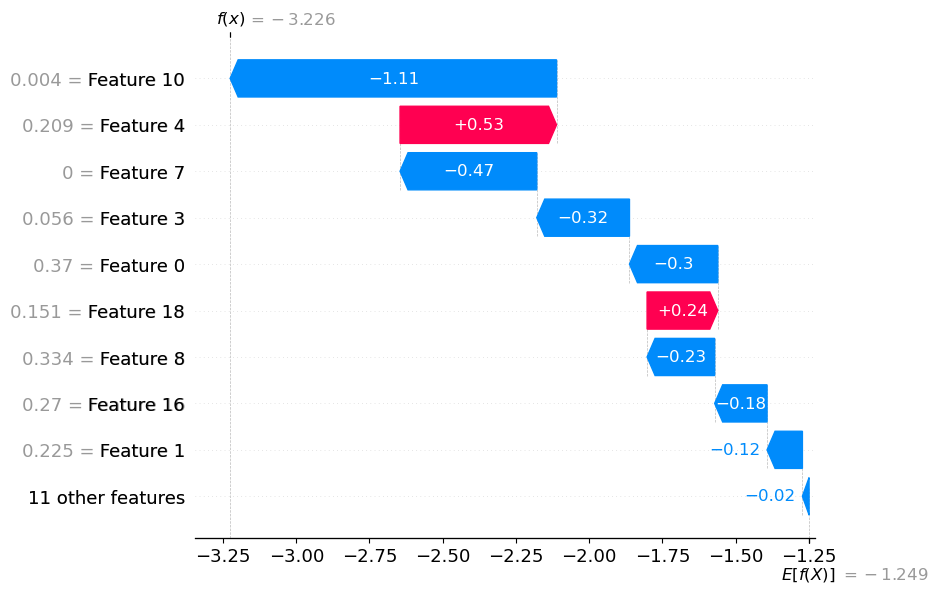

In [14]:
shap.plots.waterfall(shap_values_Kernel[4])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


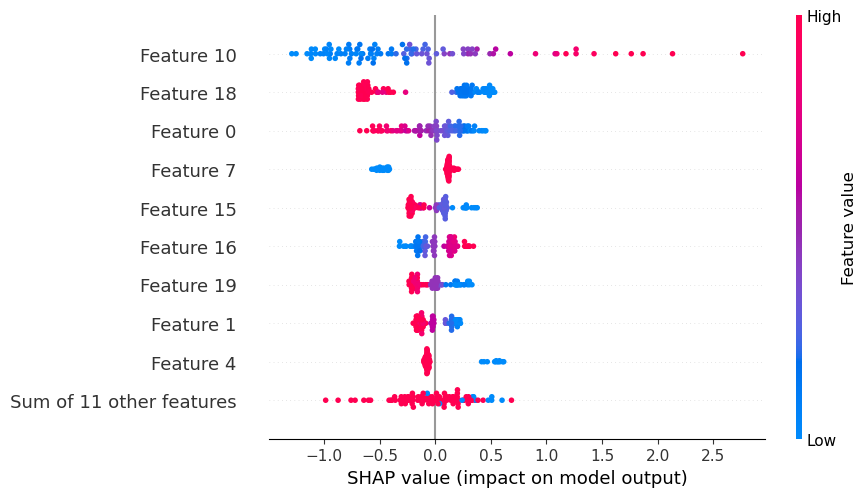

In [15]:
plt.figure(figsize=(8, 8))
shap.plots.beeswarm(shap_values_Kernel, max_display=10,show=False)
# plt.savefig('./ShapPic/'+'{}'.format(dataset_select)+'beeswarm分析.png', dpi=300,  bbox_inches='tight') # 保存图像

In [22]:
plt.figure(figsize=(8, 8))
shap.plots.heatmap(shap_values_Kernel,show=False)

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

<Figure size 800x800 with 0 Axes>

## DeepExplainer

In [10]:
def MHCS_PredictProba_Deep(X_test):
    # 单条数据预处理和转换
    # input_data = torch.tensor(X_test, dtype=torch.float32)  # 假设数据维度为(10,)
    if input_data.ndim == 1:
        input_data = input_data.view(1,-1)
    all_proba = []
    with torch.no_grad():
        output = MHCS_model(input_data).cpu()
        # print(output)
        for i in output.numpy():
            data = (i-min_value)/(max_value-min_value)
            all_proba.append(np.array([1-data, data]).reshape(1, 2).tolist())
        all_proba = np.concatenate(all_proba)
    return all_proba[:, 1]

In [11]:
MHCSexplainer = shap.DeepExplainer(MHCS_model,torch.tensor(X_test[:400].values, dtype=torch.float32))

In [12]:
data_X_test = torch.tensor(X_test[401:500].values, dtype=torch.float32).to(device)
deep_shap_values = MHCSexplainer.shap_values(data_X_test)

In [27]:
shap.initjs()
shap.force_plot(MHCSexplainer.expected_value[0], deep_shap_values[80],X_test[400:].columns.tolist())

In [48]:
type(MHCSexplainer.expected_value)

numpy.ndarray

## 公式合并

In [2]:
class MHCS_PredictProbaClass:
    def __init__(self,min_value,max_value,MHCS_model):
        self.min_value = min_value
        self.max_value = max_value
        self.MHCS_model = MHCS_model
    
    def MHCS_PredictProba(self, X_test):
        # 单条数据预处理和转换
        input_data = torch.tensor(X_test, dtype=torch.float32)  # 假设数据维度为(10,)
        if input_data.ndim == 1:
            input_data = input_data.view(1,-1)
        input_data_copy = input_data
        if input_data.size(0) == 1:
            input_data_copy = torch.cat((input_data, input_data), dim=0)
        all_proba = []
        with torch.no_grad():
            output = self.MHCS_model(input_data_copy).cpu()
            if input_data.size(0) == 1:
                output = torch.mean(output).unsqueeze(0).unsqueeze(0)
            # print(output)
            for i in output.numpy():
                data = (i-self.min_value)/(self.max_value-self.min_value)
                all_proba.append(np.array([1-data, data]).reshape(1, 2).tolist())
            all_proba = np.concatenate(all_proba)
        return all_proba[:, 1]

In [7]:
dataset_information = [
                       ['bank-additional-full-deonehot', 'Bank', 41189, 20, 4, 0.3],
                       ['celeba_baldvsnonbald_normalised','CelebA',202600, 39, 3, 0.6],
                        ['census-income-full-mixed-binarized', 'Census', 299286, 100, 50, 0.14],
                       ['creditcardfraud_normalised', 'Fraud',284808, 29, 1, 0.5],
                       ['shuttle_normalization', 'Shuttle',49098, 9, 3, 0.6],
                        ['annthyroid_21feat_normalised', 'Thyroid', 7201, 21, 3, 0.5],
                       ['UNSW_NB15_traintest_backdoor-deonehot', 'Backdoor', 95330, 42, 6, 0.5],
                       ['mammography_normalization', 'Mammography', 11183, 6, 2, 0.4]
                        ] #no
device = "cpu"
for numb, information in enumerate(dataset_information):
    block_size = information[3]
    sample_size = information[4]
    dataset_select = information[0]
    name = information[1]
    score_data = pd.read_csv('./PreDataForModel/'+dataset_select+'_val_results.csv')
    max_value = score_data['pre_val'].max()+0.0005
    min_value = score_data['pre_val'].min()-0.0005
    # print(max_value,min_value)
    all_data = pd.read_csv('./FeatureDataForModel/'+dataset_select+'_val.csv')
    x_df = all_data.drop(['class'],axis=1)
    y_df = all_data['class']
    # 划分数据集
    X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=42, shuffle=True )
    # 导入模型
    MHCS_model = ADTransformer(block_size=block_size, num_layers=8, heads= sample_size , device=device).to(device)
    MHCS_model.eval()
    
    state_dict = torch.load('./Model_best/Transformer_Base_'+ dataset_select +'.pt', map_location=device)
    MHCS_model.load_state_dict(state_dict)
    MHCS_Predict = MHCS_PredictProbaClass(min_value,max_value,MHCS_model)
    # kernalShap
    # explainer_Kernel = shap.KernelExplainer(MHCS_Predict.MHCS_PredictProba, X_test.iloc[0:100, :].values, link='logit')
    # shap_values_Kernel = explainer_Kernel(X_test.iloc[401:1000, :])
    # with open('./ShapKernalExplanation/'+"{}_explanation.pkl".format(name), 'wb') as f:
    #     pickle.dump(shap_values_Kernel, f)

    # deepShap
    # MHCSexplainer = shap.DeepExplainer(MHCS_model,torch.tensor(X_test[:400].values, dtype=torch.float32))
    # deep_shap_values = MHCSexplainer.shap_values(torch.tensor(X_test[401:1000].values, dtype=torch.float32).to(device))
    # with open('./ShapDeepExplanationData/'+"{}_explanation.pkl".format(name), 'wb') as f:
    #     pickle.dump(deep_shap_values, f)
    # # 将数组保存到文件中
    # np.save('./ShapDeepExplanationData/'+"{}_explanation.npy".format(name), MHCSexplainer.expected_value)
    ## 构造explain
    # explainer = shap.Explainer(MHCS_Predict.MHCS_PredictProba, X_test.median().values.reshape((1, X_test.shape[1])))
    # shap_values = explainer(X_test.iloc[401:1000, :])
    # with open('./ShapExplanationData/'+"{}_explanation.pkl".format(name), 'wb') as f:
    #     pickle.dump(shap_values, f)

Permutation explainer: 600it [17:53,  1.80s/it]                                                                        
Permutation explainer: 600it [23:13,  2.34s/it]                                                                        
Permutation explainer: 600it [35:51,  3.60s/it]                                                                        
Permutation explainer: 498it [05:18,  1.51it/s]                                                                        
Exact explainer: 600it [01:27,  6.13it/s]                                                                              
Permutation explainer: 505it [15:50,  1.90s/it]                                                                        
Permutation explainer: 600it [11:34,  1.18s/it]                                                                        
Exact explainer: 461it [00:43,  8.16it/s]                                                                              


In [4]:
dataset_information = [
                       # ['bank-additional-full-deonehot', 'Bank', 41189, 20, 4, 0.3],
                       # ['celeba_baldvsnonbald_normalised','CelebA',202600, 39, 3, 0.6],
                        # ['census-income-full-mixed-binarized', 'Census', 299286, 100, 50, 0.14],
                        # ['census-income-full-mixed-deonehot', 'CensusDeonehot', 299286, 40, 4, 0.15],
                       # ['creditcardfraud_normalised', 'Fraud',284808, 29, 1, 0.5],
                       ['shuttle_normalization', 'Shuttle',49098, 9, 3, 0.6],
                        # ['annthyroid_21feat_normalised', 'Thyroid', 7201, 21, 3, 0.5],
                       # ['UNSW_NB15_traintest_backdoor-deonehot', 'Backdoor', 95330, 42, 6, 0.5],
                        # ['UNSW_NB15_traintest_backdoor_kaggle', 'BackdoorKaggle', 175341, 53, 1, 0.5],
                       # ['mammography_normalization', 'Mammography', 11183, 6, 2, 0.4]
                        ] #no
device = "cpu"
for numb, information in enumerate(dataset_information):
    block_size = information[3]
    sample_size = information[4]
    dataset_select = information[0]
    name = information[1]
    score_data = pd.read_csv('./PreDataForModel/'+dataset_select+'_val_results.csv')
    max_value = score_data['pre_val'].max()+0.0005
    min_value = score_data['pre_val'].min()-0.0005
    # print(max_value,min_value)
    all_data = pd.read_csv('./FeatureDataForModel/'+dataset_select+'_val.csv')
    x_df = all_data.drop(['class'],axis=1)
    y_df = all_data['class']
    # 划分数据集
    X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=42, shuffle=True )
    # 导入模型
    MHCS_model = ADTransformer(block_size=block_size, num_layers=8, heads= sample_size , device=device).to(device)
    MHCS_model.eval()
    
    state_dict = torch.load('./Model_best/Transformer_Base_'+ dataset_select +'.pt', map_location=device)
    MHCS_model.load_state_dict(state_dict)
    MHCS_Predict = MHCS_PredictProbaClass(min_value,max_value,MHCS_model)
    # kernalShap
    # explainer_Kernel = shap.KernelExplainer(MHCS_Predict.MHCS_PredictProba, X_test.iloc[0:100, :].values, link='logit')
    # shap_values_Kernel = explainer_Kernel(X_test.iloc[401:1000, :])
    # with open('./ShapKernalExplanation/'+"{}_explanation.pkl".format(name), 'wb') as f:
    #     pickle.dump(shap_values_Kernel, f)

    # deepShap
    # MHCSexplainer = shap.DeepExplainer(MHCS_model,torch.tensor(X_test[:400].values, dtype=torch.float32))
    # deep_shap_values = MHCSexplainer.shap_values(torch.tensor(X_test[401:1000].values, dtype=torch.float32).to(device))
    # with open('./ShapDeepExplanationData/'+"{}_explanation.pkl".format(name), 'wb') as f:
    #     pickle.dump(deep_shap_values, f)
    # # 将数组保存到文件中
    # np.save('./ShapDeepExplanationData/'+"{}_explanation.npy".format(name), MHCSexplainer.expected_value)
    ## 构造explain
    explainer = shap.Explainer(MHCS_Predict.MHCS_PredictProba, X_test.median().values.reshape((1, X_test.shape[1])))
    shap_values = explainer(X_test.iloc[401:1000, :])
    with open('./ShapExplanationData/'+"{}_explanation.pkl".format(name), 'wb') as f:
        pickle.dump(shap_values, f)

Exact explainer: 600it [01:30,  6.30it/s]                                                                              


In [31]:
np.where(test.values==1)

(array([  1,   4,   5,   6,   9,  11,  14,  15,  16,  17,  18,  19,  20,
         21,  26,  28,  30,  31,  32,  33,  34,  40,  47,  50,  57,  58,
         59,  60,  62,  63,  64,  65,  68,  69,  72,  73,  74,  75,  76,
         79,  80,  83,  84,  85,  87,  89,  90,  91,  92,  93,  94,  95,
         97,  99, 102, 109, 111, 112, 115, 119, 120, 125, 128, 129, 131,
        132, 134, 137, 139, 142, 143, 144, 145, 146, 147, 148, 159, 160,
        163, 164, 166, 169, 171, 172, 173, 174, 176, 179, 180, 183, 184,
        185, 186, 188, 190, 195, 196, 198, 200, 203, 205, 208, 211, 212,
        215, 217, 218, 219, 220, 222, 223, 224, 225, 226, 228, 230, 232,
        234, 235, 236, 240, 244, 248, 251, 252, 254, 257, 259, 261, 262,
        263, 264, 267, 269, 275, 277, 278, 282, 283, 284, 285, 287, 289,
        295, 296, 297, 299, 301, 304, 307, 308, 309, 313, 319, 320, 321,
        323, 324, 325, 329, 330, 331, 332, 335, 337, 342, 348, 349, 350,
        354, 356, 362, 363, 364, 366, 367, 368, 370

## 导入解释器 绘图

In [8]:
dataset_information = [
                       # ['bank-additional-full-deonehot', 'Bank', 41189, 20, 4, 0.3], ## 465
                       # ['celeba_baldvsnonbald_normalised','CelebA',202600, 39, 3, 0.6],
                        # ['census-income-full-mixed-binarized', 'Census', 299286, 100, 50, 0.14],
                        # ['census-income-full-mixed-deonehot', 'CensusDeonehot', 299286, 40, 4, 0.15],
                       # ['creditcardfraud_normalised', 'Fraud',284808, 29, 1, 0.5],
                       ['shuttle_normalization', 'Shuttle',49098, 9, 3, 0.6],
                        # ['annthyroid_21feat_normalised', 'Thyroid', 7201, 21, 3, 0.5],
                       # ['UNSW_NB15_traintest_backdoor-deonehot', 'Backdoor', 95330, 42, 6, 0.5],
                       # ['mammography_normalization', 'Mammography', 11183, 6, 2, 0.4]
                        ] #no
## name , anomaly,normal
dataset_sample = {
                'Bank':{"Anomaly":[185,1,111],"Normal":[29,42,151]},
                  'Shuttle':{'Anomaly':[3,18,67],'Normal':[1,16,20]},
                 }

index_label = 'Normal'
device = "cpu"
# for numb, information in enumerate(dataset_information):
block_size = dataset_information[0][3]
sample_size = dataset_information[0][4]
dataset_select = dataset_information[0][0]
name = dataset_information[0][1]
score_data = pd.read_csv('./PreDataForModel/'+dataset_select+'_val_results.csv')
max_value = score_data['pre_val'].max()+0.0005
min_value = score_data['pre_val'].min()-0.0005
# print(max_value,min_value)
all_data = pd.read_csv('./FeatureDataForModel/'+dataset_select+'_val.csv')
x_df = all_data.drop(['class'],axis=1)
y_df = all_data['class']
# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=42, shuffle=True )

test = y_test.iloc[401:1000]
print(np.where(test.values==0))
print(test.loc[test==1].index)
# 加载保存的 Explanation 对象
with open('./ShapExplanationData/'+"{}_explanation.pkl".format(name), 'rb') as f:
    shap_value = pickle.load(f)

# Normal data
indexs = dataset_sample[name].get(index_label)
for index_numb in indexs:
        # # 绘图
    ## 局部
    # shap.plots.waterfall(shap_value[index_numb],show=True)
    shap.plots.waterfall(shap_value[index_numb], max_display=10,show=False)
    plt.xticks(fontsize=20)  # 设置 X 轴刻度字体大小为 10
    plt.yticks(fontsize=20)  # 设置 Y 轴刻度字体大小为 10
    # plt.tick_params(axis='both', which='major', labelsize=30)
    plt.title("{}_{}".format(name,index_label), fontdict={'family' : 'Times New Roman', 'size'   : 30})
    plt.savefig('./ShapPic/'+'{}_waterfall_{}_{}'.format(name,index_label,index_numb)+'_SHAP.png', bbox_inches='tight', dpi=300) # 保存图像
    plt.close()
    # expected_value = np.load('./ShapPic/'+"{}_explanation.npy".format(name))
    ## 全局
    # shap.plots.beeswarm(shap_value,show=False)
    # plt.savefig('./ShapPic/'+'{}_beeswarm'.format(name)+'_SHAP.png', bbox_inches='tight', dpi=300) # 保存图像
    # plt.close()
    # plt.figure(figsize=(8, 8))
    # shap.plots.heatmap(shap_value,show=False)
    # plt.savefig('./ShapPic/'+'{}_heatmap'.format(name)+'_SHAP.png', dpi=300,  bbox_inches='tight') # 保存图像
    # plt.close()
index_label = 'Anomaly'
indexs = dataset_sample[name].get(index_label)
for index_numb in indexs:
        # # 绘图
    ## 局部
    # shap.plots.waterfall(shap_value[index_numb],show=True)
    shap.plots.waterfall(shap_value[index_numb], max_display=10,show=False)
    plt.xticks(fontsize=20)  # 设置 X 轴刻度字体大小为 10
    plt.yticks(fontsize=20)  # 设置 Y 轴刻度字体大小为 10
    # 设置坐标刻度的大小
    # plt.tick_params(axis='both', which='major', labelsize=30)
    plt.title("{}_{}".format(name,index_label), fontdict={'family' : 'Times New Roman', 'size'   : 30})
    plt.savefig('./ShapPic/'+'{}_waterfall_{}_{}'.format(name,index_label,index_numb)+'_SHAP.png', bbox_inches='tight', dpi=300) # 保存图像
    plt.close()

(array([  1,   2,   4,   5,   6,   7,  10,  11,  12,  13,  15,  16,  17,
        19,  20,  21,  22,  24,  25,  27,  28,  29,  30,  31,  32,  34,
        36,  37,  38,  39,  40,  41,  42,  44,  46,  47,  49,  50,  52,
        54,  55,  56,  57,  58,  61,  62,  63,  64,  65,  69,  74,  76,
        78,  80,  81,  82,  83,  85,  87,  89,  91,  93,  94,  97,  99,
       100, 103, 105, 106, 108, 110, 112, 114, 115, 116, 118, 119, 120,
       121, 123, 125, 126, 127, 128, 129, 131, 134, 135, 136, 137, 138,
       143, 145, 146, 147, 149, 152, 153, 154, 155, 156, 157, 158, 160,
       161, 163, 164, 166, 167, 169, 170, 171, 172, 173, 176, 182, 183,
       184, 186, 189, 191, 192, 193, 194, 197, 198, 199, 200, 201, 202,
       203, 204, 205, 206, 208, 210, 211, 212, 213, 214, 215, 216, 217,
       220, 221, 222, 223, 224, 225, 227, 228, 229, 230, 232, 237, 238,
       240, 242, 245, 247, 251, 252, 254, 255, 256, 257, 260, 262, 263,
       264, 265, 269, 270, 272, 273, 275, 278, 279, 283, 284, 2

## 全局可解释性绘图

In [8]:
dataset_information = [
                       # ['bank-additional-full-deonehot', 'Bank', 41189, 20, 4, 0.3], ## 465
                       # ['celeba_baldvsnonbald_normalised','CelebA',202600, 39, 3, 0.6],
                        # ['census-income-full-mixed-binarized', 'Census', 299286, 100, 50, 0.14],
                        # ['census-income-full-mixed-deonehot', 'CensusDeonehot', 299286, 40, 4, 0.15],
                       # ['creditcardfraud_normalised', 'Fraud',284808, 29, 1, 0.5],
                       ['shuttle_normalization', 'Shuttle',49098, 9, 3, 0.6],
                        # ['annthyroid_21feat_normalised', 'Thyroid', 7201, 21, 3, 0.5],
                       # ['UNSW_NB15_traintest_backdoor-deonehot', 'Backdoor', 95330, 42, 6, 0.5],
                       # ['mammography_normalization', 'Mammography', 11183, 6, 2, 0.4]
                        ] #no
## name , anomaly,normal
dataset_sample = {'Bank':{"Anomaly":[185,1,111],"Normal":[29,42,151]},
                  'Shuttle':{'Anomaly':[3,18,67],'Normal':[1,16,20]},
                 }

index_label = 'Normal'


device = "cpu"
# for numb, information in enumerate(dataset_information):
block_size = dataset_information[0][3]
sample_size = dataset_information[0][4]
dataset_select = dataset_information[0][0]
name = dataset_information[0][1]
score_data = pd.read_csv('./PreDataForModel/'+dataset_select+'_val_results.csv')
max_value = score_data['pre_val'].max()+0.0005
min_value = score_data['pre_val'].min()-0.0005
# print(max_value,min_value)
all_data = pd.read_csv('./FeatureDataForModel/'+dataset_select+'_val.csv')
x_df = all_data.drop(['class'],axis=1)
y_df = all_data['class']
# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=42, shuffle=True )

test = y_test.iloc[401:1000]
print(np.where(test.values==0))
print(test.loc[test==1].index)
# 加载保存的 Explanation 对象
with open('./ShapExplanationData/'+"{}_explanation.pkl".format(name), 'rb') as f:
    shap_value = pickle.load(f)

# Normal data
# indexs = dataset_sample[name].get(index_label)
# for index_numb in indexs:
# plt.savefig('./ShapPic/'+'{}_waterfall_{}_{}'.format(name,index_label,index_numb)+'_SHAP.png', bbox_inches='tight', dpi=300) # 保存图像
# plt.close()
# expected_value = np.load('./ShapPic/'+"{}_explanation.npy".format(name))
## 全局
plt.figure(figsize=(8, 8))
shap.plots.beeswarm(shap_value,show=False)
plt.xticks(fontsize=12)  # 设置 X 轴刻度字体大小为 10
plt.yticks(fontsize=12)  # 设置 Y 轴刻度字体大小为 10
# plt.tick_params(axis='both', which='major', labelsize=30)
plt.title("SHAP Value of MHCS-Net in {} Dataset".format(name), fontdict={'family' : 'Times New Roman', 'size'   : 15})
plt.savefig('./ShapPic/'+'{}_beeswarm'.format(name)+'_SHAP.png', bbox_inches='tight', dpi=300) # 保存图像
plt.close()
plt.figure(figsize=(8, 8))
shap.plots.heatmap(shap_value,show=False)
plt.xticks(fontsize=12)  # 设置 X 轴刻度字体大小为 10
plt.yticks(fontsize=12)  # 设置 Y 轴刻度字体大小为 10
# plt.tick_params(axis='both', which='major', labelsize=30)
plt.title("SHAP Value of MHCS-Net in {} Dataset".format(name), fontdict={'family' : 'Times New Roman', 'size'   : 15})
plt.savefig('./ShapPic/'+'{}_heatmap'.format(name)+'_SHAP.png', dpi=300,  bbox_inches='tight') # 保存图像
plt.close()

(array([  1,   2,   4,   5,   6,   7,  10,  11,  12,  13,  15,  16,  17,
        19,  20,  21,  22,  24,  25,  27,  28,  29,  30,  31,  32,  34,
        36,  37,  38,  39,  40,  41,  42,  44,  46,  47,  49,  50,  52,
        54,  55,  56,  57,  58,  61,  62,  63,  64,  65,  69,  74,  76,
        78,  80,  81,  82,  83,  85,  87,  89,  91,  93,  94,  97,  99,
       100, 103, 105, 106, 108, 110, 112, 114, 115, 116, 118, 119, 120,
       121, 123, 125, 126, 127, 128, 129, 131, 134, 135, 136, 137, 138,
       143, 145, 146, 147, 149, 152, 153, 154, 155, 156, 157, 158, 160,
       161, 163, 164, 166, 167, 169, 170, 171, 172, 173, 176, 182, 183,
       184, 186, 189, 191, 192, 193, 194, 197, 198, 199, 200, 201, 202,
       203, 204, 205, 206, 208, 210, 211, 212, 213, 214, 215, 216, 217,
       220, 221, 222, 223, 224, 225, 227, 228, 229, 230, 232, 237, 238,
       240, 242, 245, 247, 251, 252, 254, 255, 256, 257, 260, 262, 263,
       264, 265, 269, 270, 272, 273, 275, 278, 279, 283, 284, 2

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


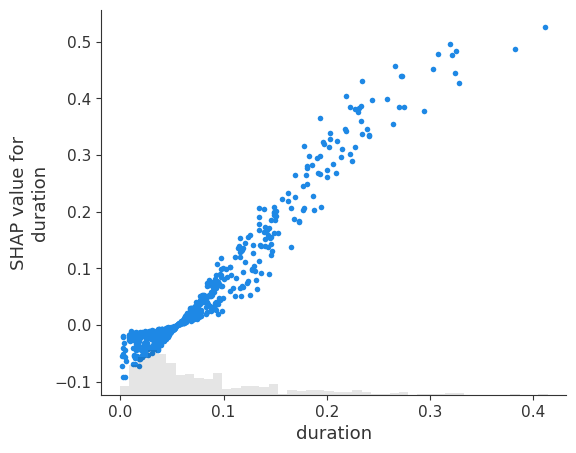

In [58]:
shap.plots.scatter(shap_value[:, "duration"])

## 导入DeepExplain

In [ ]:
dataset_information = [
                       ['bank-additional-full-deonehot', 'Bank', 41189, 20, 4, 0.3], ## 465
                       # ['celeba_baldvsnonbald_normalised','CelebA',202600, 39, 3, 0.6],
                        # ['census-income-full-mixed-binarized', 'Census', 299286, 100, 50, 0.14],
                        # ['census-income-full-mixed-deonehot', 'CensusDeonehot', 299286, 40, 4, 0.15],
                       # ['creditcardfraud_normalised', 'Fraud',284808, 29, 1, 0.5],
                       # ['shuttle_normalization', 'Shuttle',49098, 9, 3, 0.6],
                        # ['annthyroid_21feat_normalised', 'Thyroid', 7201, 21, 3, 0.5],
                       # ['UNSW_NB15_traintest_backdoor-deonehot', 'Backdoor', 95330, 42, 6, 0.5],
                       # ['mammography_normalization', 'Mammography', 11183, 6, 2, 0.4]
                        ] #no
## name , anomaly,normal
dataset_sample = {'Bank':{"Anomaly":185,"Normal":29},
                  'Census':{"Anomaly":185,"Normal":29}
                 }
# index_label = 'Anomaly'
index_label = 'Normal'


device = "cpu"
# for numb, information in enumerate(dataset_information):
block_size = dataset_information[0][3]
sample_size = dataset_information[0][4]
dataset_select = dataset_information[0][0]
name = dataset_information[0][1]
score_data = pd.read_csv('./PreDataForModel/'+dataset_select+'_val_results.csv')
max_value = score_data['pre_val'].max()+0.0005
min_value = score_data['pre_val'].min()-0.0005
# print(max_value,min_value)
all_data = pd.read_csv('./FeatureDataForModel/'+dataset_select+'_val.csv')
x_df = all_data.drop(['class'],axis=1)
y_df = all_data['class']
# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=42, shuffle=True )

test = y_test.iloc[401:1000]
print(np.where(test.values==0))
print(test.loc[test==1].index)
# 加载保存的 Explanation 对象
with open('./ShapExplanationData/'+"{}_explanation.pkl".format(name), 'rb') as f:
    shap_value = pickle.load(f)
    

index_numb = dataset_sample[name].get(index_label)
    # # 绘图
## 局部
# shap.plots.waterfall(shap_value[index_numb],show=True)
shap.plots.waterfall(shap_value[index_numb],show=False)
plt.xticks(fontsize=20)  # 设置 X 轴刻度字体大小为 10
plt.yticks(fontsize=20)  # 设置 Y 轴刻度字体大小为 10
plt.title("{}_{}".format(name,index_label), fontdict={'family' : 'Times New Roman', 'size'   : 24})
plt.savefig('./ShapPic/'+'{}_waterfall_{}_{}'.format(name,index_label,index_numb)+'_SHAP.png', bbox_inches='tight', dpi=300) # 保存图像
# expected_value = np.load('./ShapPic/'+"{}_explanation.npy".format(name))
## 全局
# shap.plots.beeswarm(shap_value,show=False)
# plt.savefig('./ShapPic/'+'{}_beeswarm'.format(name)+'_SHAP.png', bbox_inches='tight', dpi=300) # 保存图像
    # plt.figure(figsize=(8, 8))
# shap.plots.heatmap(shap_value,show=False)
# plt.savefig('./ShapPic/'+'{}_heatmap'.format(name)+'_SHAP.png', dpi=300,  bbox_inches='tight') # 保存图像
